# Convergence Tests for the Affine-Invariant Ensemble Sampler

The Affine-Invariant Ensemble Sampler (AIES) is a Monte-Carlo method particularly popular in astrophysics. The paper describing its widely used Python implementation [emcee](http://dan.iel.fm/emcee/) is highly cited and the method is particularly popular because it has -- aside from the number of walkers, i.e., the number of chains -- no tunable parameters.

Huijser, Goodman, and Brewer recently highlighted some [convergence problems](http://arxiv.org/abs/1509.02230) in AIES. This is illustrated in the case of correlated Gaussians, specifically in the auto-regressive process of order 1, aka AR(1). This blog post sets out to test whether a simple convergence criterion can discover these problems.

## The Autoregressive (1) Process

Huijser, Goodman, and Brewer use the so-called autoregressive process of order 1 (aka AR(1)) to highlight slow convergence of the AIES algorithm when the dimensionality of the problem exceeds a few and correlations between parameters exist. We start by reproducing their findings.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import emcee
import corner

We set up the covariance matrix for the AR(1) process in 10, 50, and 100 dimensions.

In [2]:
ndim_arr = [10, 50, 100]
α = 0.9
cov_arr = []
for ndim in ndim_arr:
    idx = np.repeat(np.arange(ndim), ndim).reshape(ndim, ndim)
    Σ = α**abs(idx - idx.T)  
    cov_arr.append(Σ)    

Let's first illustrate the correlated distribution for the 10-dimensional case.

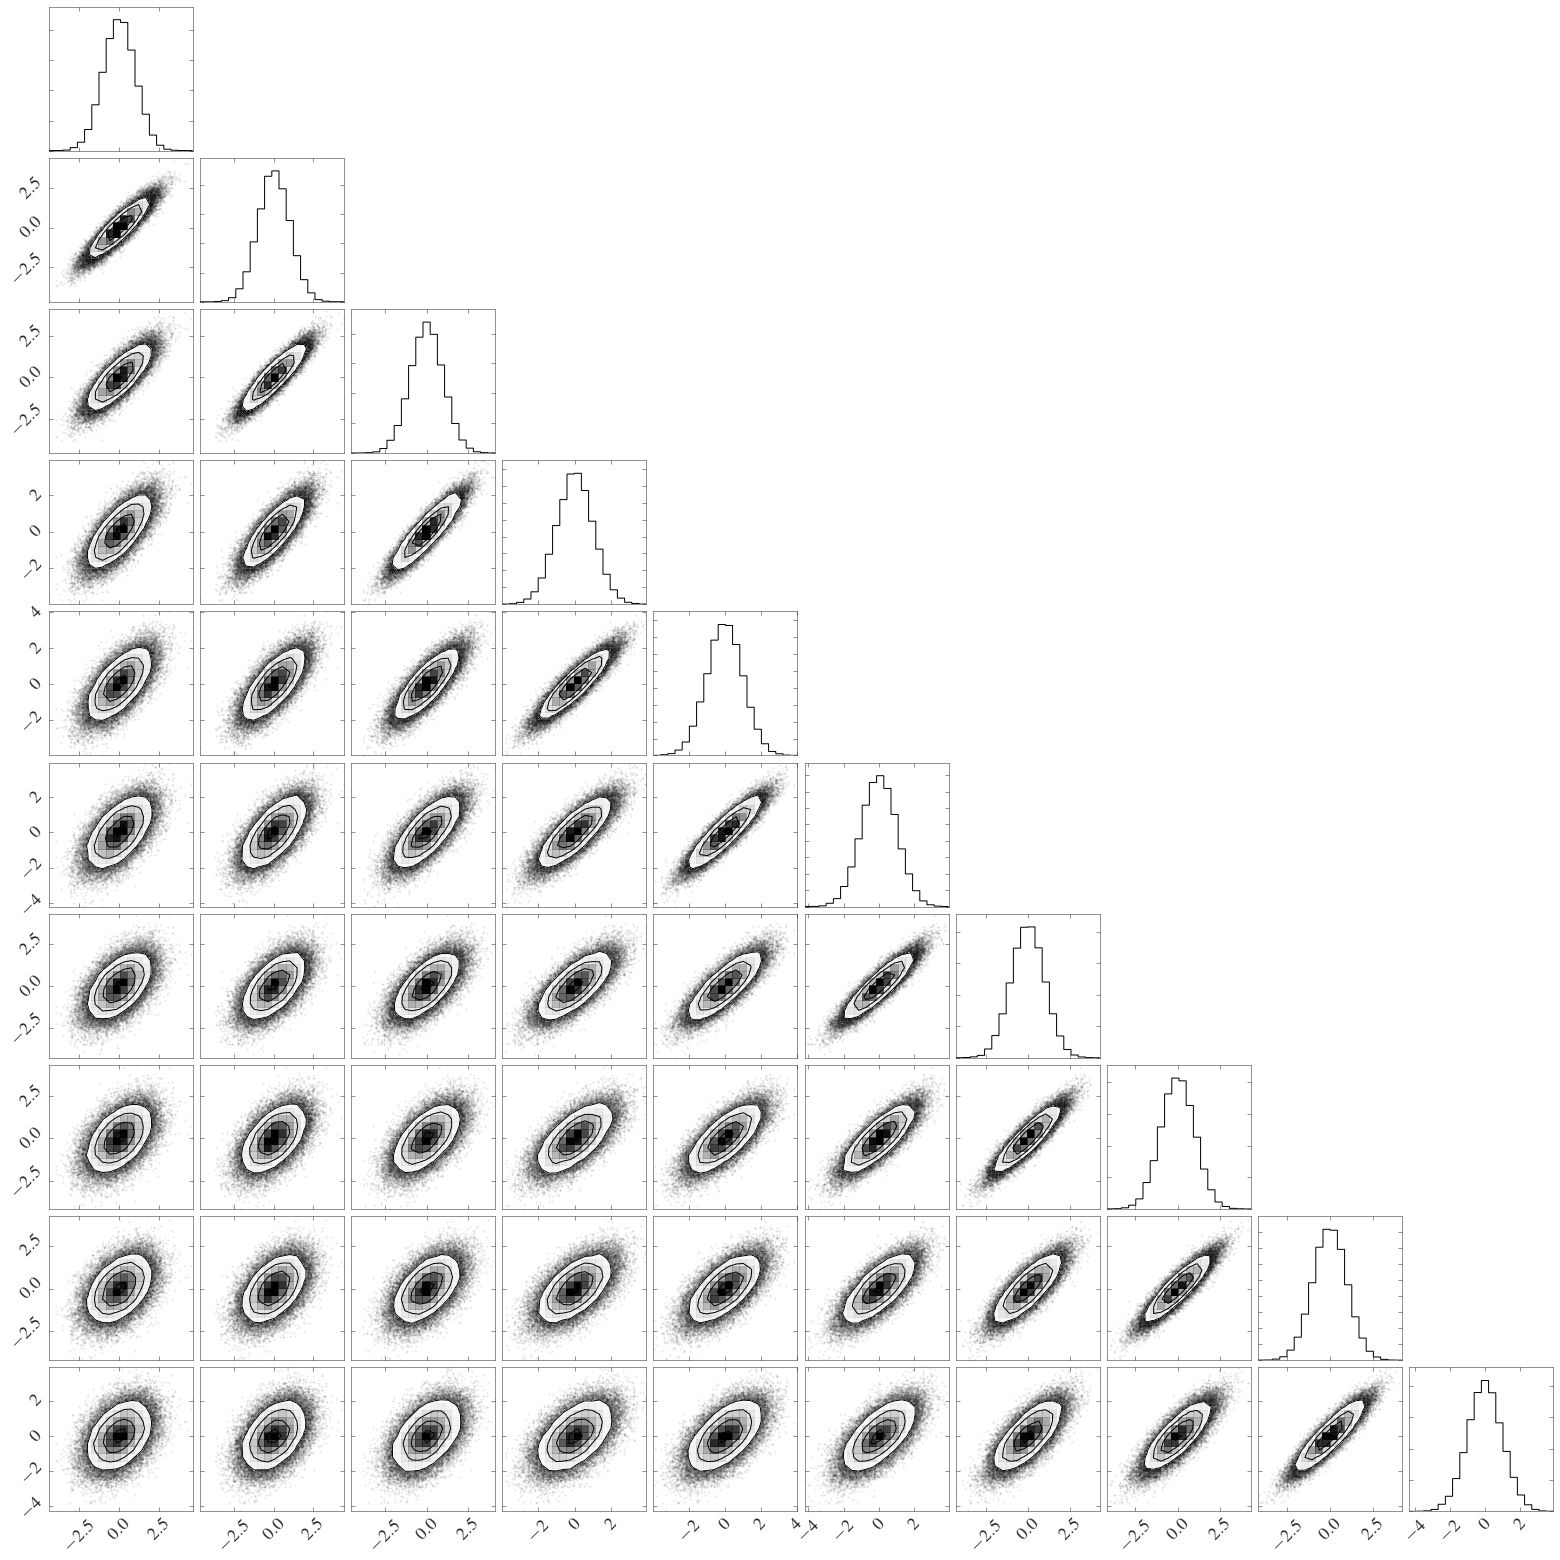

In [3]:
X = np.random.multivariate_normal(np.zeros(ndim_arr[0]), cov_arr[0], 50000)
figure = corner.corner(X)

Next we set up the likelihood function and run emcee on all three sets of covariances. Without loss of generality and for illustration we look only at the zeroth parameter.

In [4]:
def lnprob(x, μ, icov):
    diff = x - μ
    return -np.dot(diff, np.dot(icov, diff)) / 2

chains = []
nprod = 5000
print("ndim\tμ\t\tσ\tacceptance fraction")
print("===================================================")
for ndim, cov in list(zip(ndim_arr, cov_arr)):
    icov = np.linalg.inv(cov)
    means = np.zeros(ndim)
    nwalkers = 2 * ndim
    p0 = np.random.normal(size=ndim * nwalkers).reshape((nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])
    # Burn in
    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    # Production run
    pos, prob, state = sampler.run_mcmc(pos, nprod)
    # Skip 5 autocorrelation times at the beginning of the chain.
    skip = int(5 * sampler.acor.max())
    chain = sampler.chain[:, skip:, :]
    chains.append(chain)
    print("{0:3d}\t{1: 5.4f}\t\t{2:5.4f}\t\t{3:5.4f}".format(
            ndim, 
            chain.reshape(-1, chain.shape[-1]).mean(axis=0)[0],
            chain.reshape(-1, chain.shape[-1]).std(axis=0)[0],
            np.mean(sampler.acceptance_fraction)))

ndim	μ		σ	acceptance fraction
 10	 0.0039		1.0235		0.4170
 50	-0.0401		0.9155		0.1876
100	 0.0410		0.5856		0.1327


The correct results is, of course, a mean of 0, which is obtained for all three cases, and a standard deviation of 1. As highlighted by Huijser et al. the chains show insufficient mixing for the higher dimensional cases and dramatically underestimate the variance of the posterior distribution.

## The Gelman-Rubin Test

Huijser et al. do not go into attempts to test convergence criteria that can detect this behavior. Because the slow convergence is highlighted in the low variance of the chains, the Gelman-Rubin test is a natural approach. First proposed by [Gelman and Rubin in 1992](http://www.stat.columbia.edu/~gelman/research/published/itsim.pdf), this test compares the variance within one chain, $W$, with the variance between chains $B$. Both variances are combined in a weighted sum to obtain an estimate of the variance of a parameter $\theta$. The square root of the ratio of this estimates variance to the within chain variance

$$\hat R = \sqrt{\frac{\hat{\mathrm{Var}}(\theta)}{W}}$$

is called the potential scale reduction. For a well converged chain it should approach 1. Values greater than typically 1.1 indicate that the chains have not yet fully converged.

The Gelman-Rubin criterion can be naturally applied to multi-chain methods such as AIES. Although the walkers in AIES communicate at every step, the target distribution is composed of independent walkers and the Gelman-Rubin test is applicable.

In [5]:
def gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    θb = np.mean(chain, axis=1)
    θbb = np.mean(θb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((θbb - θb)**2, axis=0)
    var_θ = (n - 1) / n * W + 1 / n * B
    R̂ = np.sqrt(var_θ / W)
    return R̂

Now that we have a Python routine for the Gelman-Rubin test, let's apply it to our chains from the AR(1) process:

In [6]:
print("ndim\tμ\t\tσ\tGelman-Rubin")
print("============================================")
for ndim, chain in list(zip(ndim_arr, chains)):
        print("{0:3d}\t{1: 5.4f}\t\t{2:5.4f}\t\t{3:3.2f}".format(
            ndim, 
            chain.reshape(-1, chain.shape[-1]).mean(axis=0)[0],
            chain.reshape(-1, chain.shape[-1]).std(axis=0)[0],
            gelman_rubin(chain)[0]))

ndim	μ		σ	Gelman-Rubin
 10	 0.0039		1.0235		1.02
 50	-0.0401		0.9155		1.18
100	 0.0410		0.5856		1.45


We clearly see that the Gelman-Rubin tests detects the problematic posterior variance values. This is helpful because the convergence particulary in the 100 dimensional case is so slow that trace plots of the variance are almost useless. We can look at how the potential scale reduction develops as a function of chain length:

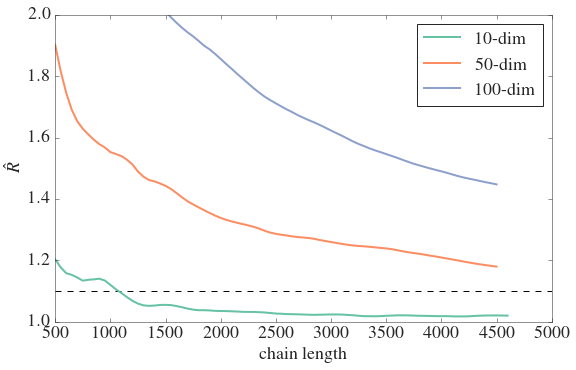

In [7]:
fig = plt.figure(figsize=(8.9, 5.5))
xmin = 500
for ndim, chain in list(zip(ndim_arr, chains)):
    chain_length = chain.shape[1]
    step_sampling = np.arange(xmin, chain_length, 50)
    rhat = np.array([gelman_rubin(chain[:, :steps, :])[0] for steps in step_sampling])
    plt.plot(step_sampling, rhat, label="{:d}-dim".format(ndim), linewidth=2)
    
ax = plt.gca()
xmax = ax.get_xlim()[1]
plt.hlines(1.1, xmin, xmax, linestyles="--")
plt.ylabel("$\hat R$")
plt.xlabel("chain length")
plt.ylim(1, 2)
legend = plt.legend(loc='best')

The 10 dimensional case crosses our convergence criterion of $\hat R < 1.1$ after a relatively short run of about 1100 steps after burn-in while the higher dimensional cases creep towards convergence at a rate that can only be described as unsatisfactory given how simple this problem is.

## Conclusions

While this blog post doesn't solve the slow convergence of AIES in cases like this one it shows that a simple and well established convergence criterion, the Gelman-Rubin test, can easily discover such problematic behavior. The Gelman-Rubin test should thus be an essential step in ascertaining the convergence of chains from the AIES. Reliance on trace plots and autocorrelation lengths is not sufficient.

<small>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">This blog post is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>. This post was written as a <a href="http://www.jupyter.org/">Jupyter Notebook</a> in Python. You can <a href="https://raw.githubusercontent.com/joergdietrich/joergdietrich.github.io/master/notebooks/AIES_AR1.ipynb">download</a> the original notebook.</small>